In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir

Welcome to JupyROOT 6.15/01


In [2]:
class particle:
    def __init__(self, pid, fourvector, virtual_photon):
        self.virtual_photon = virtual_photon #z-axis with respect to the lab
        Nu = virtual_photon.E()
        Q2 = -virtual_photon.M2()
        self.proton = ROOT.TLorentzVector()
        self.proton.SetPxPyPzE(0,0,0, 0.938)
        self.W = (virtual_photon + self.proton).M()
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.0,5.0)####INCONSISTENT
        part1 = virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        
        self.LorentzVector = fourvector #hadron four-vector
        self.PhiLab = self.LorentzVector.Phi()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star)
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.Xb = Q2/(2*0.938*Nu)

        
    def print_properties(self):
        print 'Hello, let me introduce myself, i am particle pid = ' , self.pid
        print 'zh = ', self.Zh, ' phi_pq= ', self.PhiPQ, ' theta_pq=' , self.ThetaPQ, 'E = ', self.E, ' xf', self.Xf,'Pt ', self.Pt, ' Pl= ', self.Pl, ' rapidity=' ,  self.y


In [3]:
class mytupla:
    def __init__(self):
        self.tupla = {}
        variables = ['dphi','dphi_lab','qt','dy','z','z_asso','z_tot','xf','xf_asso',
                     'y', 'ycm','y_asso','pid','pid_asso','phi_pq','phi_pq_asso',
                      'theta_pq','theta_pq_asso','dipion_pt','missing_mass','mass',
                      'Q2','Xb','Nu','W','phi_lab','theta_lab','phi_lab_asso','theta_lab_asso',
                       'pos_x', 'pos_y','pos_z','pos_x_asso', 'pos_y_asso','pos_z_asso']
        
        for var in variables:
            self.tupla[var] = []
        
        trigger_variables = ['pid','xf','z','y','ycm','Q2','Xb','Nu','W','phi_pq','theta_pq',
                             'TargType','phi_lab','theta_lab','pos_x','pos_y','pos_z']
        
        self.tupla_trigger = {}
        for var in trigger_variables:
            self.tupla_trigger[var] = []    

In [6]:

def getDataframes(filename, Target=1,maxevents=1e9,beamenergy=5.0):
    dphi = np.array([])
    ParticlesFromPrevious = []
    try:
        myfile = TFile.Open('%s'%filename,'READ')
    except:
        print("could not open file")

        
    myfile.Print()
    mytree = myfile.Get('RootTuple')
    
    print filename, ' has ', mytree.GetEntries(), ' entries'
    print 'The max number of events to be analyzes is ', maxevents
    df = mytupla()    
    
    start = time.time()
    for ievt  in range(mytree.GetEntries()):
        if(ievt%1e5==0):
            print 'Event # ', ievt
            end = time.time()
            print 'Processed in',  end-start, 'seconds'
            start = time.time()
        mytree.GetEntry(ievt)   
        if mytree.Q2<1.0: continue
        if ievt>maxevents: break
        Nu = mytree.nu
        Q2 = mytree.Q2
        phi_e = mytree.phiL 
        E    = beamenergy
        Eprime = E-Nu
        
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,E,E)
        
        #scattered electron
        scattered_e = ROOT.TLorentzVector()
        cos_thetae = 1-Q2/(2*E*Eprime)
        sin_thetae = np.sqrt(1-cos_thetae*cos_thetae)
        scattered_e.SetPxPyPzE(Eprime*sin_thetae*np.cos(phi_e),
                               Eprime*sin_thetae*np.sin(phi_e),
                               Eprime*cos_thetae,
                               Eprime)
        virtual_photon  = incoming_e - scattered_e
        virtual_photon_unitvector = virtual_photon.Vect().Unit()

        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)
        #print virtual_photon.M2(), ' ' , Q2
        #print virtual_photon.Vect().Mag(), ' ' , np.sqrt(Nu*Nu+Q2*Q2)
        
        #virtual_photon = ROOT.TLorentzVector()
        #virtual_photon.SetPxPyPzE( 0, 0, np.sqrt(Nu*Nu+Q2*Q2),Nu)  #lab frame but with z in photon direction 
        #cos_thetaphoton = E -Eprime
        
        #need to rotate to lab frame with z aligned with beam frame
        #virtual_photon.Rotate()
        #### virtual photon 
        #electron in lab frame = (0,0,E,E)
        #scattered electron in lab frame = (E'sintheta*cosphi,E'sintheta'sinphi,E'costheta,E')
        
        #Q2= 2EE'(1-cos_thetae)
        # cos_thetae =1- Q2/2EE'

        #photon in lab frame is e-e'
        # (-E'sintheta*cosphi, -E'sintheta*sinphi, E-E'costheta, E-E')
        
        #cos_thetaphoton = (E- E'*costheta)/(E-E')
        #cos_thetaphoton = (E- E'*(1- Q2/2EE'))/(E-E')
        #sin_thetaphoton = sqrt(1-cos_thetaphoton*cos_thetaphoton)
        #Thus, photon pT in lab frame with z-lepton direction is:
        #pT = E'sqrt(1-cos_thetaphoton^{2})
        #pT = E'sqrt(1- (E- E'*(1- Q2/2EE'))/(E-E')^{2} )
        #and finally, photon phi angle is:
        # phi_photon = -phi_electron (given)
      
        for i in range(len(mytree.Px)):
            if abs(mytree.barcode[i]) !=211: continue
            i_lv = ROOT.TLorentzVector()    
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.E[i]) #with respect to photon direction
            i_part = particle(mytree.barcode[i], i_lv, virtual_photon)
            if i_part.Zh > 0.5:
                df.tupla_trigger['TargType'].append(999)
                df.tupla_trigger['pid'].append(i_part.pid)
                df.tupla_trigger['xf'].append(i_part.Xf)
                df.tupla_trigger['z'].append(i_part.Zh)
                df.tupla_trigger['y'].append(i_part.y_star)
                df.tupla_trigger['ycm'].append(i_part.ycm)
                df.tupla_trigger['phi_pq'].append(i_part.PhiPQ)
                df.tupla_trigger['theta_pq'].append(i_part.ThetaPQ)
                df.tupla_trigger['Q2'].append(Q2)
                df.tupla_trigger['Xb'].append(i_part.Xb)
                df.tupla_trigger['Nu'].append(Nu)
                df.tupla_trigger['W'].append(i_part.W)
                df.tupla_trigger['phi_lab'].append(i_part.LorentzVector.Phi())
                df.tupla_trigger['theta_lab'].append(i_part.LorentzVector.Theta())
                df.tupla_trigger['pos_x'].append(mytree.x[i])
                df.tupla_trigger['pos_y'].append(mytree.y[i])
                df.tupla_trigger['pos_z'].append(mytree.z[i])
                for j in range(len(mytree.Px)): 
                    if i==j: continue
                    if abs(mytree.barcode[j]) !=211: continue
                    j_lv = ROOT.TLorentzVector()    
                    j_lv.SetPxPyPzE(mytree.Px[j],mytree.Py[j],mytree.Pz[j],mytree.E[j])
                    j_part = particle(mytree.barcode[j], j_lv, virtual_photon)
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-j_part.PhiPQ))
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-j_part.PhiLab))
                    dipion = i_part.LorentzVector+j_part.LorentzVector
                    qt = dipion.Pt()
                    X = (virtual_photon + proton - dipion) #unobserved hadronic system

                    
            
                    
                    df.tupla['dphi'].append(dphi)
                    df.tupla['dphi_lab'].append(dphi_lab)
                    df.tupla['qt'].append(qt)
                    df.tupla['dy'].append(i_part.y-j_part.y)
                    df.tupla['z'].append(i_part.Zh)
                    df.tupla['z_asso'].append(j_part.Zh)
                    df.tupla['z_tot'].append(i_part.Zh+j_part.Zh)
                    df.tupla['xf'].append(i_part.Xf)
                    df.tupla['xf_asso'].append(j_part.Xf)
                    df.tupla['y'].append(i_part.y_star)
                    df.tupla['ycm'].append(i_part.ycm)
                    df.tupla['y_asso'].append(j_part.y_star)
                    df.tupla['pid'].append(i_part.pid)
                    df.tupla['pid_asso'].append(j_part.pid)
                    df.tupla['phi_pq'].append(i_part.PhiPQ)
                    df.tupla['phi_pq_asso'].append(j_part.PhiPQ)
                    df.tupla['theta_pq'].append(i_part.ThetaPQ)
                    df.tupla['theta_pq_asso'].append(j_part.ThetaPQ)
                    df.tupla['mass'].append(dipion.M())
                    df.tupla['dipion_pt'].append( dipion.Pt())
                    df.tupla['missing_mass'].append(X.M())
                    df.tupla['Q2'].append(Q2)
                    df.tupla['Xb'].append(i_part.Xb)
                    df.tupla['Nu'].append(Nu)
                    df.tupla['W'].append(i_part.W)
                    df.tupla['phi_lab'].append(i_part.LorentzVector.Phi())
                    df.tupla['theta_lab'].append(i_part.LorentzVector.Theta())
                    df.tupla['phi_lab_asso'].append(j_part.LorentzVector.Phi())
                    df.tupla['theta_lab_asso'].append(j_part.LorentzVector.Theta())
                    df.tupla['pos_x'].append(mytree.x[i])
                    df.tupla['pos_y'].append(mytree.y[i])
                    df.tupla['pos_z'].append(mytree.z[i])
                    df.tupla['pos_x_asso'].append(mytree.x[j])
                    df.tupla['pos_y_asso'].append(mytree.y[j])
                    df.tupla['pos_z_asso'].append(mytree.z[j])
        
        
    end = time.time()
    print 'Processed in',  end-start, 'seconds'
    df_pair = pd.DataFrame(df.tupla)
    df_trigger = pd.DataFrame(df.tupla_trigger)
    return df_pair, df_trigger

In [7]:
df = {}

## Configuration for CLAS6

In [8]:
name_Fe = 'GiBUU_Fe.root'
nevents = 5e6
beamenergy = 5.0

## Configuration for HERMES

In [ ]:
name_D = 'GiBUU/hermes/GiBUU_Hermes_D.root'
name_Kr = 'GiBUU/hermes/GiBUU_Hermes_Kr.root'
name_Xe = 'GiBUU/hermes/GiBUU_Hermes_Xe.root'
nevents = 5e6
beamenergy = 27.6

## Configuration for CLAS12

In [9]:
name_Pb = 'gibuu_clas12_Pb.root'
name_D = 'gibuu_clas12_D.root'
nevents = 5e3
beamenergy = 11.0

In [13]:
df['D'], df['D_trigger'] = getDataframes('GiBUU/D/GiBUU_D.root',maxevents=1e5)

GiBUU/D/GiBUU_D.root  has  2458112  entries
The max number of events to be analyzes is  100000.0
Event #  0
Processed in 0.124514102936 seconds
Event #  100000
Processed in 173.793227911 seconds
Processed in 0.0324268341064 seconds
TFile: name=GiBUU/D/GiBUU_D.root, title=, option=READ


In [14]:
df['C'], df['C_trigger'] = getDataframes('GiBUU/Carbon/GiBUU_C.root',maxevents=1e5)

GiBUU/Carbon/GiBUU_C.root  has  2566117  entries
The max number of events to be analyzes is  100000.0
Event #  0
Processed in 0.0374269485474 seconds
Event #  100000
Processed in 184.215522051 seconds
Processed in 0.0289690494537 seconds
TFile: name=GiBUU/Carbon/GiBUU_C.root, title=, option=READ


In [15]:
df['Fe'], df['Fe_trigger'] = getDataframes('GiBUU/Iron/GiBUU_Fe.root',maxevents=1e5)

GiBUU/Iron/GiBUU_Fe.root  has  1852429  entries
The max number of events to be analyzes is  100000.0
Event #  0
Processed in 0.028491973877 seconds
Event #  100000
Processed in 170.068274021 seconds
Processed in 0.0208101272583 seconds
TFile: name=GiBUU/Iron/GiBUU_Fe.root, title=, option=READ


In [16]:
df['Pb'], df['Pb_trigger'] = getDataframes('GiBUU/Lead/GiBUU_Pb.root',maxevents=1e5)

GiBUU/Lead/GiBUU_Pb.root  has  1800379  entries
The max number of events to be analyzes is  100000.0
Event #  0
Processed in 0.0355150699615 seconds
Event #  100000
Processed in 171.744135857 seconds
Processed in 0.0159080028534 seconds
TFile: name=GiBUU/Lead/GiBUU_Pb.root, title=, option=READ


In [ ]:
df['Pb'], df['Pb_trigger'] = getDataframes(name_Pb,maxevents=nevents,beamenergy=beamenergy)

In [ ]:
df['Kr'], df['Kr_trigger'] = getDataframes(name_Kr,maxevents=nevents,beamenergy=beamenergy)

In [ ]:
df['Xe'], df['Xe_trigger'] = getDataframes(name_Xe,maxevents=nevents,beamenergy=beamenergy)

In [ ]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

In [ ]:
print df['Pb'].shape[0]
print df['Pb_trigger'].shape[0]

In [ ]:
print df['D'].shape[0]
print df['D_trigger'].shape[0]

## Save dataframes to ROOT files

In [ ]:
to_root(df['D'],'GiBUU_Pairs_D.root', key='D')
to_root(df['D_trigger'],'GiBUU_Pairs_D.root', key='D_trigger', mode='a')

In [ ]:
to_root(df['C'],'GiBUU_Pairs_C.root', key='C')
to_root(df['C_trigger'],'GiBUU_Pairs_C.root', key='C_trigger', mode='a')

In [ ]:
to_root(df['Fe'],'GiBUU_Pairs_Fe.root', key='Fe')
to_root(df['Fe_trigger'],'GiBUU_Pairs_Fe.root', key='Fe_trigger', mode='a')

In [ ]:
to_root(df['Pb'],'GiBUU_Pairs_Pb.root', key='Pb')
to_root(df['Pb_trigger'],'GiBUU_Pairs_Pb.root', key='Pb_trigger', mode='a')

In [ ]:
## HERMES

In [ ]:
to_root(df['D'],'GiBUU_Pairs_HERMES_D.root', key='D')
to_root(df['D_trigger'],'GiBUU_Pairs_HERMES_D.root', key='D_trigger', mode='a')
to_root(df['Kr'],'GiBUU_Pairs_HERMES_Kr.root', key='Kr')
to_root(df['Kr_trigger'],'GiBUU_Pairs_HERMES_Kr.root', key='Kr_trigger', mode='a')

In [ ]:
to_root(df['Xe'],'GiBUU_Pairs_HERMES_Xe.root', key='Xe')
to_root(df['Xe_trigger'],'GiBUU_Pairs_HERMES_Xe.root', key='Xe_trigger', mode='a')

## CLAS12

In [ ]:
to_root(df['D'],'GiBUU_Pairs_CLAS12_D.root', key='D')
to_root(df['D_trigger'],'GiBUU_Pairs_CLAS12_D.root', key='D_trigger', mode='a')
to_root(df['Pb'],'GiBUU_Pairs_CLAS12_Pb.root', key='Pb')
to_root(df['Pb_trigger'],'GiBUU_Pairs_CLAS12_Pb.root', key='Pb_trigger', mode='a')

## Check dataframes variables

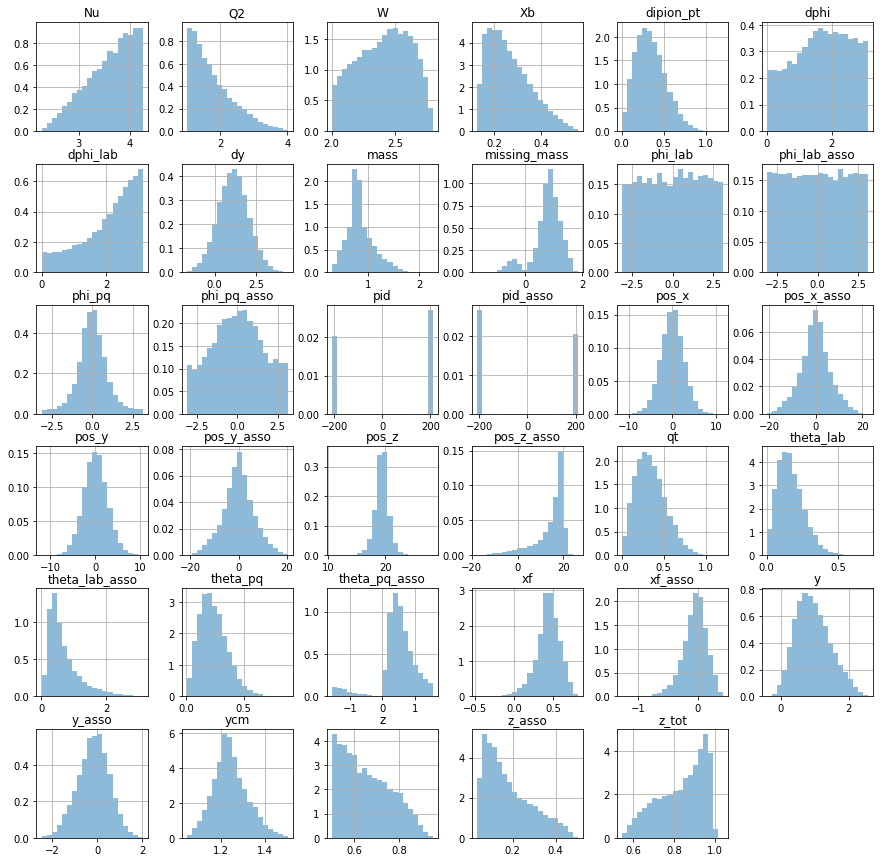

In [17]:
df['D'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=20)
plt.show()

In [ ]:
df['Fe_trigger'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=100)
plt.show()

In [ ]:
df['D'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=20)
plt.show()

In [ ]:
y_D, x , _  = plt.hist(df['D']['z_asso'],bins=100,normed=True,alpha=0.7,label='D')
y_C, x , _  = plt.hist(df['Pb']['z_asso'],bins=100,normed=True,alpha=0.7,label='C')
x = (x[1:] + x[:-1])/2.0
plt.legend()
plt.show()

In [ ]:
ratio = np.divide(y_C, y_D)
plt.errorbar(x, ratio, marker='o')

plt.ylim([0.0,2.5])
plt.show()

## Broadening

0.017203903489962674
0.022602676669221028
0.04095527160509471


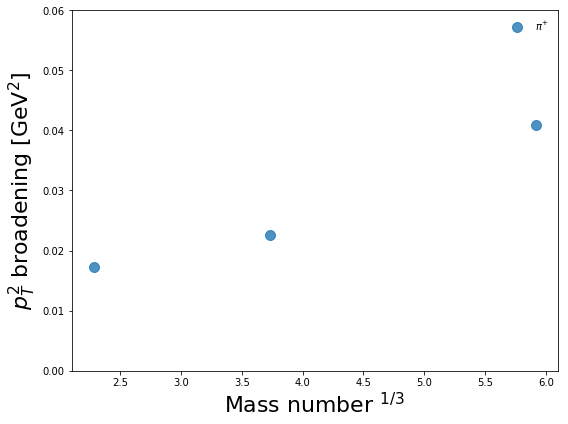

In [18]:
broadening_pip = []
mass_number = [12,52,208]
mass_number_cubicroot = [2.28, 3.73,5.92]
fig = plt.figure(figsize=(8,6))
broadening_pim= []

selection = 'z_asso>0.1 and Nu<3 and Nu>2 and Q2<2 and Q2>1'


df['D'].eval('qt2 = qt*qt', inplace=True)
df['Fe'].eval('qt2 = qt*qt', inplace=True)
df['C'].eval('qt2 = qt*qt', inplace=True)
df['Pb'].eval('qt2 = qt*qt', inplace=True)


ref = df['D'].query(selection)['qt2'].mean()
for target in ['C','Fe','Pb']:
    A = df['%s'%target].query(selection)['qt2'].mean()
    print A-ref
    #print A
    broadening_pip.append(A-ref)

plt.plot(mass_number_cubicroot,broadening_pip,'o',ms=10,alpha=0.8,label='$\pi^{+}$')

#plt.title(r'$0.5<z<0.6$ , $2.0<\nu<3.0$',fontsize=22)
plt.ylabel('$p_{T}^{2}$ broadening [GeV$^{2}$]',fontsize=22)
plt.xlabel('Mass number $^{1/3}$',fontsize=22)
plt.legend(loc='best',ncol=3,frameon=False)
plt.ylim([0.0,0.06])

#plt.xscale('log')
plt.tight_layout()
plt.savefig('Broadening.png')